In [2]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from math import sqrt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

2024-03-20 13:29:09.002990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional

In [4]:
batch_size = 32  # This is the number of samples per gradient update.
time_steps = 100  # This is the 'window' of time steps you're looking at to predict the next step.
features = 1  # For univariate data, the number of features is 1.

model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, stateful=True, batch_input_shape=(batch_size, time_steps, features)),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=True, stateful=True),
    Dropout(0.2),
    LSTM(50, activation='relu', stateful=True),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


# USDC Univariate LSTM Time Series

Approximately 2,000 samples

In [5]:
def json_to_prices(json):
    df = pd.read_json(json)
    prices = df['prices']
    coin_prices = pd.DataFrame(prices.tolist(), columns=['time', 'price'])
    prices = coin_prices['price']
    return prices

In [6]:
prices = json_to_prices('usdc90days.json')
print(prices)

0       1.0003
1       0.9999
2       0.9994
3       1.0000
4       0.9989
         ...  
2155    0.9974
2156    1.0000
2157    1.0005
2158    0.9987
2159    1.0001
Name: price, Length: 2160, dtype: float64


In [7]:
def normalize_prices(prices):
    normalized_prices = (prices - np.mean(prices)) / np.std(prices)
    return normalized_prices

In [8]:
# Normalize the prices data
normalized_prices = (prices - np.mean(prices)) / np.std(prices)
print(normalized_prices)

0       0.313974
1      -0.139964
2      -0.707387
3      -0.026480
4      -1.274809
          ...   
2155   -2.977077
2156   -0.026480
2157    0.540943
2158   -1.501778
2159    0.087005
Name: price, Length: 2160, dtype: float64


In [9]:
def split_data(normalized_prices, split=0.8):
    train_size = int(len(normalized_prices) * split)
    test_size = len(normalized_prices) - train_size
    
    training_data = normalized_prices[0:train_size]
    test_data = normalized_prices[train_size:len(normalized_prices)]
    return training_data, test_data

    # X_train, X_test = X[0:train_size], X[train_size:len(X)]
    # y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [10]:
def create_dataset_helper(data, time_step=1):
    X, y = [], []
    data = data.reset_index(drop=True)

    for i in range(len(data) - time_step):      
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

In [11]:
def create_dataset(data, time_steps=1):
    X, y = create_dataset_helper(data, time_steps)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    return X, y

In [12]:
time_step = 10 # This is the number of time steps you're looking at to predict the next step.

# Split the data into training and testing data
training_data, test_data = split_data(normalized_prices)
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print(test_data)

1728    0.427458
1729   -0.366933
1730   -0.253449
1731   -0.253449
1732    0.313974
          ...   
2155   -2.977077
2156   -0.026480
2157    0.540943
2158   -1.501778
2159    0.087005
Name: price, Length: 432, dtype: float64


In [13]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1718, 10, 1) (1718,) (422, 10, 1) (422,)


In [14]:
train_size = X_train.shape[0]
test_size = X_test.shape[0]
print(train_size, test_size)

1718 422


In [15]:
def create_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [16]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 50)            10400     
                                                                 
 lstm_4 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
54/54 [==============================] - 5s 10ms/step - loss: 0.9146
Epoch 2/50
54/54 [==============================] - 1s 11ms/step - loss: 0.9109
Epoch 3/50
54/54 [==============================] - 1s 9ms/step - loss: 0.9107
Epoch 4/50
54/54 [==============================] - 0s 9ms/step - loss: 0.9128
Epoch 5/50
54/54 [==============================] - 0s 9ms/step - loss: 0.9123
Epoch 6/50
54/54 [==============================] - 1s 10ms/step - loss: 0.9099
Epoch 7/50
54/54 [==============================] - 1s 11ms/step - loss: 0.9080
Epoch 8/50
54/54 [==============================] - 1s 10ms/step - loss: 0.9087
Epoch 9/50
54/54 [==============================] - 1s 10ms/step - loss: 0.9078
Epoch 10/50
54/54 [==============================] - 1s 10ms/step - loss: 0.9087
Epoch 11/50
54/54 [==============================] - 1s 10ms/step - loss: 0.9087
Epoch 12/50
54/54 [==============================] - 1s 10ms/step - loss: 0.9063
Epoch 13/50
54/54 [=====================

In [18]:
def predictions(model, X_train, y_train, X_test, y_test, prices):
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_predict = (train_predictions * np.std(prices)) + np.mean(prices)
    y_train = (y_train * np.std(prices)) + np.mean(prices)
    test_predict = (test_predictions * np.std(prices)) + np.mean(prices)
    y_test = (y_test * np.std(prices)) + np.mean(prices)
    
    train_score = sqrt(mean_squared_error(y_train, train_predict))
    print('Train Score: %.20f RMSE' % (train_score))
    test_score = sqrt(mean_squared_error(y_test, test_predict))
    print('Test Score: %.20f RMSE' % (test_score))
    return train_predict, test_predict
    

In [19]:
train_predict, test_predict = predictions(model, X_train, y_train, X_test, y_test, prices)

14/14 [==============================] - 0s 4ms/step
Train Score: 0.00079963814033133464 RMSE
Test Score: 0.00107774192404252013 RMSE


In [20]:
print(test_predict.shape)

(422, 1)


In [21]:
train_predict_flattened = train_predict.flatten()
test_predict_flattened = test_predict.flatten()

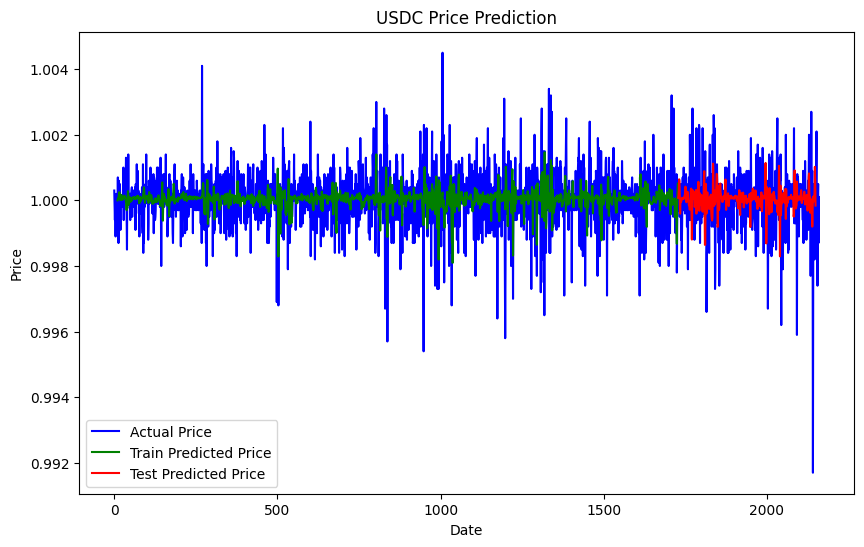

In [22]:
# graph the results

# reshape train_predict and test_predict to the shape of prices

plt.figure(figsize=(10, 6))
plt.plot(prices, color='blue', label='Actual Price')
plt.plot(range(time_step, train_size + time_step), train_predict_flattened, color='green', label='Train Predicted Price')
plt.plot(range(train_size + time_step, train_size + time_step + test_size), test_predict_flattened, color='red', label='Test Predicted Price')

plt.title('USDC Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Ethereum Univariate LSTM Time Series

In [26]:
time_step = 10

prices = json_to_prices('ethereum90days.json')
normalized_prices = normalize_prices(prices)
training_data, test_data = split_data(normalized_prices)
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
lstm = create_model()

lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test))


Epoch 1/100
54/54 [==============================] - 5s 28ms/step - loss: 0.0606 - val_loss: 0.5274
Epoch 2/100
54/54 [==============================] - 1s 10ms/step - loss: 0.0114 - val_loss: 0.5290
Epoch 3/100
54/54 [==============================] - 1s 10ms/step - loss: 0.0107 - val_loss: 0.4208
Epoch 4/100
54/54 [==============================] - 1s 10ms/step - loss: 0.0100 - val_loss: 0.4148
Epoch 5/100
54/54 [==============================] - 1s 10ms/step - loss: 0.0093 - val_loss: 0.3684
Epoch 6/100
54/54 [==============================] - 1s 10ms/step - loss: 0.0086 - val_loss: 0.3451
Epoch 7/100
54/54 [==============================] - 1s 10ms/step - loss: 0.0074 - val_loss: 0.3500
Epoch 8/100
54/54 [==============================] - 1s 11ms/step - loss: 0.0069 - val_loss: 0.2848
Epoch 9/100
54/54 [==============================] - 1s 10ms/step - loss: 0.0069 - val_loss: 0.2762
Epoch 10/100
54/54 [==============================] - 1s 10ms/step - loss: 0.0060 - val_loss: 0.2979

In [27]:
train_predict_eth, test_predict_eth = predictions(lstm, X_train, y_train, X_test, y_test, prices)

train_predict_flattened_eth = train_predict_eth.flatten()
test_predict_flattened_eth = test_predict_eth.flatten()

14/14 [==============================] - 0s 4ms/step
Train Score: 13.55766525861532478814 RMSE
Test Score: 102.62267970976634501312 RMSE


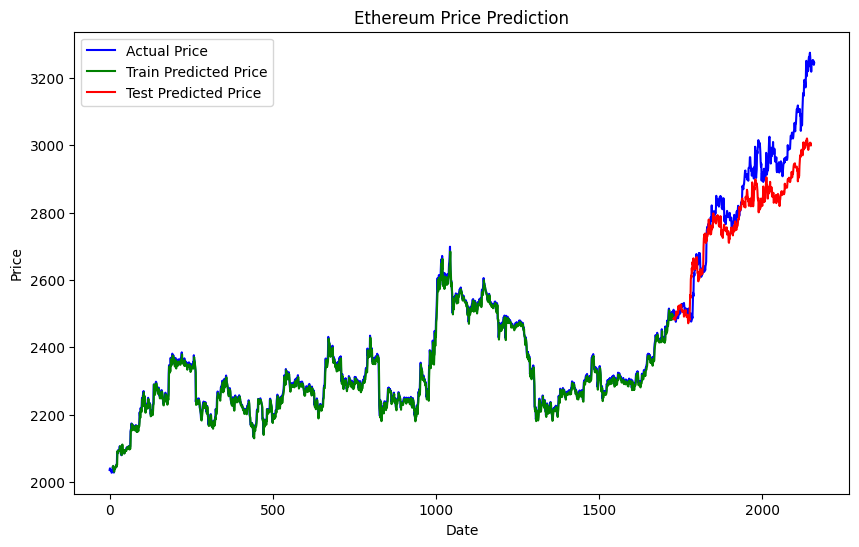

In [28]:
# graph the results of ethereum

# reshape train_predict and test_predict to the shape of prices

plt.figure(figsize=(10, 6))
plt.plot(prices, color='blue', label='Actual Price')
plt.plot(range(time_step, train_size + time_step), train_predict_flattened_eth, color='green', label='Train Predicted Price')
plt.plot(range(train_size + time_step, train_size + time_step + test_size), test_predict_flattened_eth, color='red', label='Test Predicted Price')

plt.title('Ethereum Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# DAI Univariate LSTM Time Series (Price based, 90 days: Dec 20 - Mar 19)

In [33]:
time_step = 10

prices = json_to_prices('dai90days.json')
normalized_prices = normalize_prices(prices)
training_data, test_data = split_data(normalized_prices)
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
lstm = create_model()

lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
54/54 [==============================] - 6s 34ms/step - loss: 0.8303 - val_loss: 1.0234
Epoch 2/50
54/54 [==============================] - 1s 12ms/step - loss: 0.8102 - val_loss: 1.0165
Epoch 3/50
54/54 [==============================] - 1s 14ms/step - loss: 0.8067 - val_loss: 1.0461
Epoch 4/50
54/54 [==============================] - 1s 11ms/step - loss: 0.7940 - val_loss: 0.9492
Epoch 5/50
54/54 [==============================] - 1s 12ms/step - loss: 0.7942 - val_loss: 0.9464
Epoch 6/50
54/54 [==============================] - 1s 11ms/step - loss: 0.7881 - val_loss: 0.9270
Epoch 7/50
54/54 [==============================] - 1s 12ms/step - loss: 0.7864 - val_loss: 0.9474
Epoch 8/50
54/54 [==============================] - 1s 15ms/step - loss: 0.7822 - val_loss: 0.9315
Epoch 9/50
54/54 [==============================] - 1s 14ms/step - loss: 0.7802 - val_loss: 0.9505
Epoch 10/50
54/54 [==============================] - 1s 15ms/step - loss: 0.7774 - val_loss: 0.9567
Epoch 11/

In [35]:
train_predict_dai, test_predict_dai = predictions(lstm, X_train, y_train, X_test, y_test, prices)

train_predict_flattened_dai = train_predict_dai.flatten()
test_predict_flattened_dai = test_predict_dai.flatten()

14/14 [==============================] - 0s 5ms/step
Train Score: 0.00105638964574422179 RMSE
Test Score: 0.00175878113119609897 RMSE


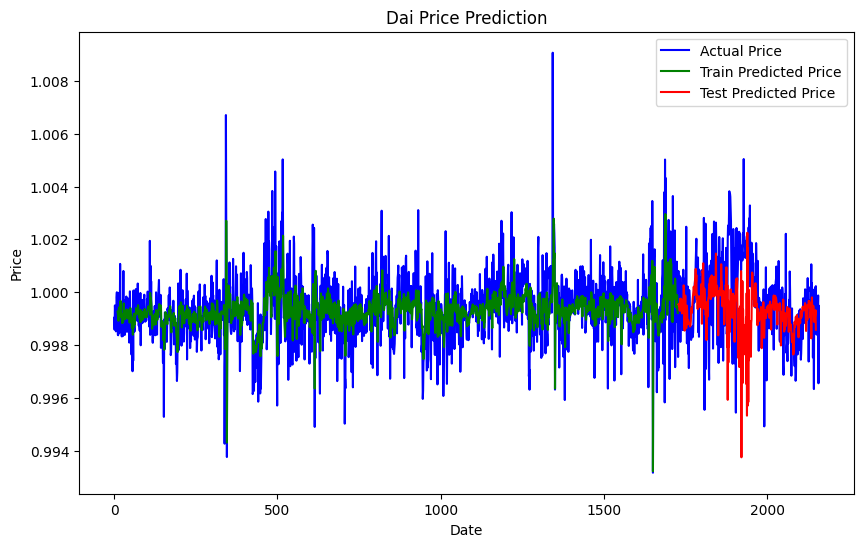

In [37]:
# graph the results of dai

# reshape train_predict and test_predict to the shape of prices

# plt.figure(figsize=(10, 6))
# plt.plot(prices, color='blue', label='Actual Price')
# plt.plot(range(time_step, train_size + time_step), train_predict_flattened_dai, color='green', label='Train Predicted Price')
# plt.plot(range(train_size + time_step, train_size + time_step + test_size), test_predict_flattened_dai, color='red', label='Test Predicted Price')

# plt.title('Dai Price Prediction')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.show()

plt.figure(figsize=(10, 6))
plt.plot(prices, color='blue', label='Actual Price')

# Adjusting the range to match the length of train_predict_flattened_dai
train_range = range(time_step, time_step + len(train_predict_flattened_dai))

plt.plot(train_range, train_predict_flattened_dai, color='green', label='Train Predicted Price')

# Assuming test_predict_flattened_dai has the same length as test_size
test_range = range(train_size + time_step, train_size + time_step + len(test_predict_flattened_dai))

plt.plot(test_range, test_predict_flattened_dai, color='red', label='Test Predicted Price')

plt.title('Dai Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# USDT Univariate LSTM Time Series

In [30]:
time_step = 10

prices = json_to_prices('usdt90days.json')
normalized_prices = normalize_prices(prices)
training_data, test_data = split_data(normalized_prices)
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
lstm = create_model()

lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
54/54 [==============================] - 6s 31ms/step - loss: 0.6307 - val_loss: 1.2739
Epoch 2/50
54/54 [==============================] - 1s 11ms/step - loss: 0.6145 - val_loss: 1.2663
Epoch 3/50
54/54 [==============================] - 1s 11ms/step - loss: 0.6167 - val_loss: 1.2758
Epoch 4/50
54/54 [==============================] - 1s 11ms/step - loss: 0.6076 - val_loss: 1.3346
Epoch 5/50
54/54 [==============================] - 1s 12ms/step - loss: 0.6172 - val_loss: 1.3682
Epoch 6/50
54/54 [==============================] - 1s 15ms/step - loss: 0.6104 - val_loss: 1.3142
Epoch 7/50
54/54 [==============================] - 1s 17ms/step - loss: 0.6071 - val_loss: 1.3782
Epoch 8/50
54/54 [==============================] - 1s 14ms/step - loss: 0.6068 - val_loss: 1.3125
Epoch 9/50
54/54 [==============================] - 1s 18ms/step - loss: 0.6068 - val_loss: 1.3583
Epoch 10/50
54/54 [==============================] - 1s 13ms/step - loss: 0.6053 - val_loss: 1.3925
Epoch 11/

In [31]:
train_predict_usdt, test_predict_usdt = predictions(lstm, X_train, y_train, X_test, y_test, prices)

train_predict_flattened_usdt = train_predict_usdt.flatten()
test_predict_flattened_usdt = test_predict_usdt.flatten()

14/14 [==============================] - 0s 8ms/step
Train Score: 0.00083920312277512043 RMSE
Test Score: 0.00138863804362669013 RMSE


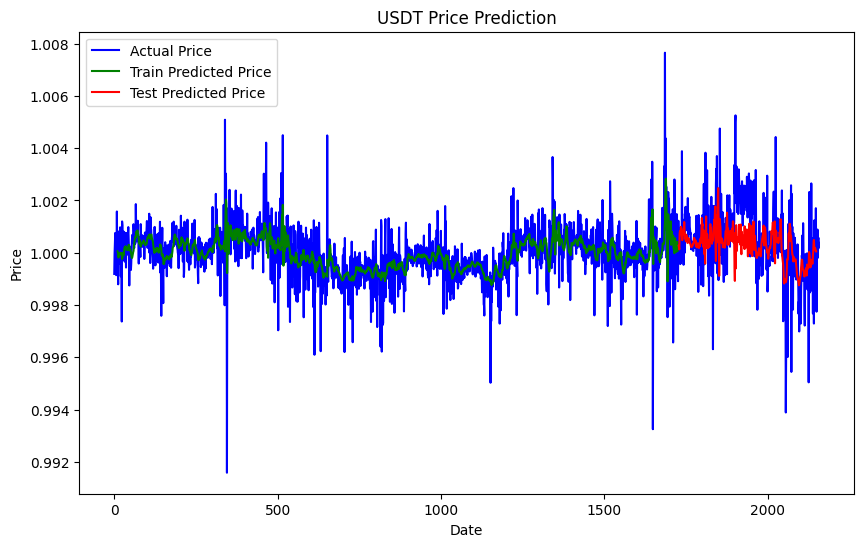

In [32]:
#graph the results of ethereum

#reshape train_predict and test_predict to the shape of prices

plt.figure(figsize=(10, 6))
plt.plot(prices, color='blue', label='Actual Price')

# Adjusting the range to match the length of train_predict_flattened_dai
train_range = range(time_step, time_step + len(train_predict_flattened_usdt))

plt.plot(train_range, train_predict_flattened_usdt, color='green', label='Train Predicted Price')

# Assuming test_predict_flattened_dai has the same length as test_size
test_range = range(train_size + time_step, train_size + time_step + len(test_predict_flattened_usdt))

plt.plot(test_range, test_predict_flattened_usdt, color='red', label='Test Predicted Price')

plt.title('USDT Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# FDUSD Univariate LSTM Time Series

In [27]:
time_step = 10

prices = json_to_prices('fdusd90days.json')
normalized_prices = normalize_prices(prices)
training_data, test_data = split_data(normalized_prices)
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
lstm = create_model()

lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
54/54 [==============================] - 6s 42ms/step - loss: 0.5639 - val_loss: 1.4036
Epoch 2/50
54/54 [==============================] - 1s 24ms/step - loss: 0.5375 - val_loss: 1.3790
Epoch 3/50
54/54 [==============================] - 1s 23ms/step - loss: 0.5335 - val_loss: 1.3848
Epoch 4/50
54/54 [==============================] - 2s 31ms/step - loss: 0.5318 - val_loss: 1.3731
Epoch 5/50
54/54 [==============================] - 1s 23ms/step - loss: 0.5301 - val_loss: 1.3890
Epoch 6/50
54/54 [==============================] - 1s 23ms/step - loss: 0.5286 - val_loss: 1.3883
Epoch 7/50
54/54 [==============================] - 1s 23ms/step - loss: 0.5258 - val_loss: 1.3816
Epoch 8/50
54/54 [==============================] - 1s 23ms/step - loss: 0.5261 - val_loss: 1.3788
Epoch 9/50
54/54 [==============================] - 1s 27ms/step - loss: 0.5236 - val_loss: 1.4037
Epoch 10/50
54/54 [==============================] - 2s 28ms/step - loss: 0.5197 - val_loss: 1.3971
Epoch 11/

In [28]:
train_predict_fdusd, test_predict_fdusd = predictions(lstm, X_train, y_train, X_test, y_test, prices)

train_predict_flattened_fdusd = train_predict_fdusd.flatten()
test_predict_flattened_fdusd = test_predict_fdusd.flatten()

14/14 [==============================] - 0s 4ms/step
Train Score: 0.00195959605257359963 RMSE
Test Score: 0.00369286489519054465 RMSE


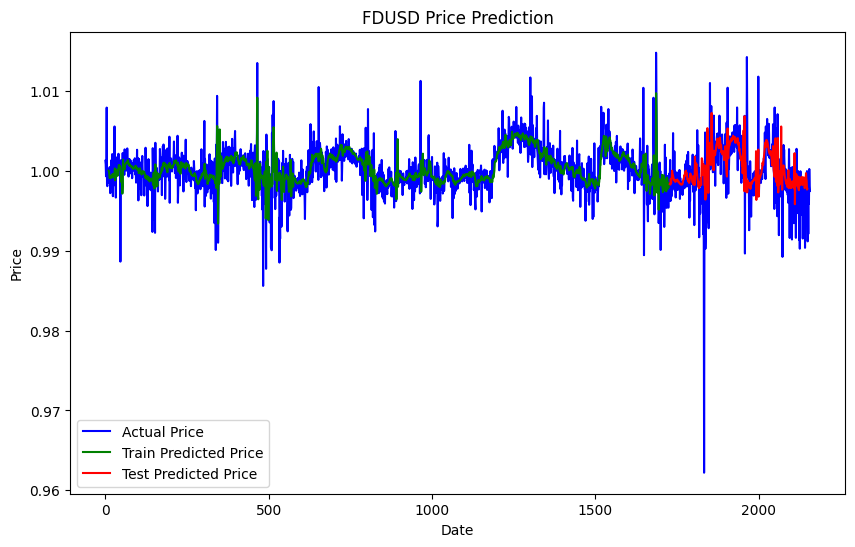

In [29]:
#graph the results of ethereum

#reshape train_predict and test_predict to the shape of prices

plt.figure(figsize=(10, 6))
plt.plot(prices, color='blue', label='Actual Price')

# Adjusting the range to match the length of train_predict_flattened_dai
train_range = range(time_step, time_step + len(train_predict_flattened_fdusd))

plt.plot(train_range, train_predict_flattened_fdusd, color='green', label='Train Predicted Price')

# Assuming test_predict_flattened_dai has the same length as test_size
test_range = range(train_size + time_step, train_size + time_step + len(test_predict_flattened_fdusd))

plt.plot(test_range, test_predict_flattened_fdusd, color='red', label='Test Predicted Price')

plt.title('FDUSD Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# USDE Univariate LSTM Time Series

In [23]:
time_step = 10

prices = json_to_prices('usde90days.json')
normalized_prices = normalize_prices(prices)
training_data, test_data = split_data(normalized_prices)
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
lstm = create_model()

lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
51/51 [==============================] - 6s 33ms/step - loss: 0.5699 - val_loss: 0.1726
Epoch 2/50
51/51 [==============================] - 1s 11ms/step - loss: 0.3847 - val_loss: 0.1774
Epoch 3/50
51/51 [==============================] - 1s 11ms/step - loss: 0.3141 - val_loss: 0.1727
Epoch 4/50
51/51 [==============================] - 1s 12ms/step - loss: 0.2793 - val_loss: 0.1726
Epoch 5/50
51/51 [==============================] - 1s 12ms/step - loss: 0.2492 - val_loss: 0.1721
Epoch 6/50
51/51 [==============================] - 1s 11ms/step - loss: 0.2300 - val_loss: 0.1678
Epoch 7/50
51/51 [==============================] - 1s 13ms/step - loss: 0.2272 - val_loss: 0.1669
Epoch 8/50
51/51 [==============================] - 1s 12ms/step - loss: 0.2190 - val_loss: 0.1663
Epoch 9/50
51/51 [==============================] - 1s 11ms/step - loss: 0.2189 - val_loss: 0.1679
Epoch 10/50
51/51 [==============================] - 1s 12ms/step - loss: 0.2228 - val_loss: 0.1639
Epoch 11/

In [24]:
train_predict_usde, test_predict_usde = predictions(lstm, X_train, y_train, X_test, y_test, prices)

train_predict_flattened_usde = train_predict_usde.flatten()
test_predict_flattened_usde = test_predict_usde.flatten()

13/13 [==============================] - 0s 4ms/step
Train Score: 0.00212136044645172637 RMSE
Test Score: 0.00196764390783209057 RMSE


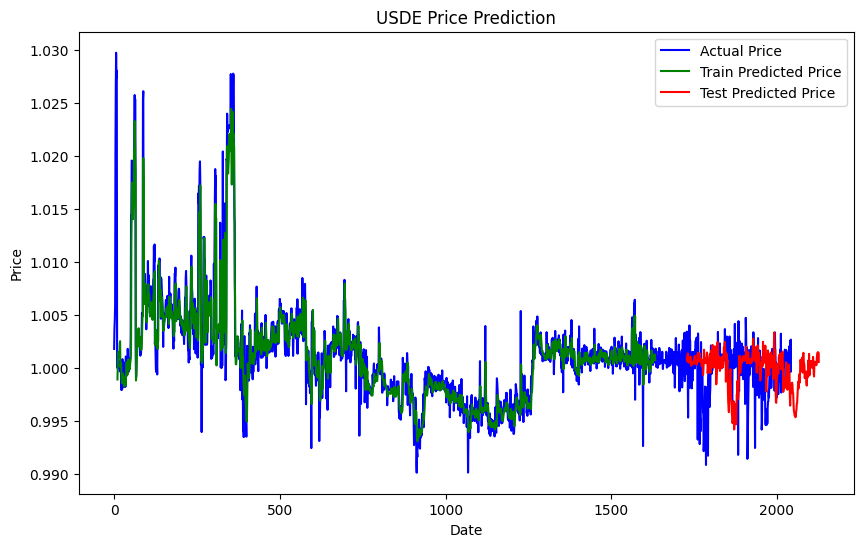

In [26]:
#reshape train_predict and test_predict to the shape of prices

plt.figure(figsize=(10, 6))
plt.plot(prices, color='blue', label='Actual Price')

# Adjusting the range to match the length of train_predict_flattened_dai
train_range = range(time_step, time_step + len(train_predict_flattened_usde))

plt.plot(train_range, train_predict_flattened_usde, color='green', label='Train Predicted Price')

# Assuming test_predict_flattened_dai has the same length as test_size
test_range = range(train_size + time_step, train_size + time_step + len(test_predict_flattened_usde))

plt.plot(test_range, test_predict_flattened_usde, color='red', label='Test Predicted Price')

plt.title('USDE Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()